18:47:17 - cmdstanpy - INFO - Chain [1] start processing
18:47:17 - cmdstanpy - INFO - Chain [1] done processing



✅ Evaluation on Hold-Out Test Set:
MAE: 412.67
RMSE: 800.90


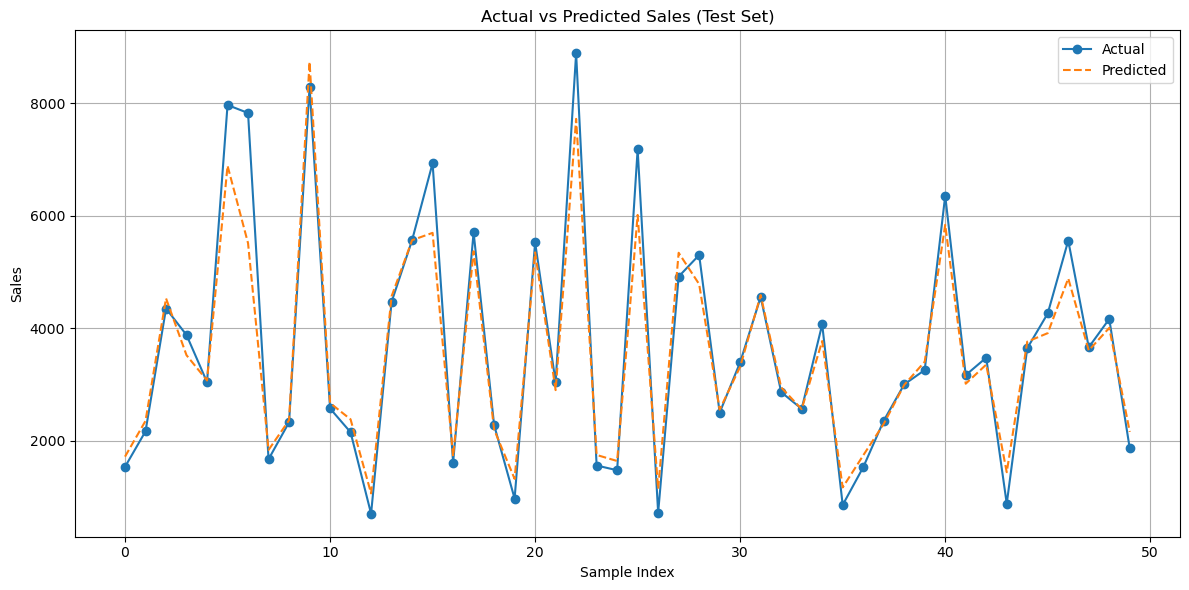

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

try:
    from prophet import Prophet
    prophet_available = True
except ImportError:
    print("⚠️ Prophet not installed. Time-series forecasting will be skipped.")
    prophet_available = False

# Load dataset
df = pd.read_csv("sales_data_sample.csv", encoding="latin1")
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

# Feature Engineering
df['year'] = df['ORDERDATE'].dt.year
df['month'] = df['ORDERDATE'].dt.month
df['day'] = df['ORDERDATE'].dt.day
df['dayofweek'] = df['ORDERDATE'].dt.dayofweek
df['weekofyear'] = df['ORDERDATE'].dt.isocalendar().week.astype(int)
df['quarter'] = df['ORDERDATE'].dt.quarter
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

# Encode categoricals
df = pd.get_dummies(df, columns=['STATUS', 'PRODUCTLINE', 'COUNTRY', 'TERRITORY'], drop_first=True)

# Prophet Forecasting
if prophet_available:
    df_prophet = df.groupby('ORDERDATE').agg({'SALES': 'sum'}).reset_index()
    df_prophet.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'}, inplace=True)
    model = Prophet()
    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

# Prepare supervised ML dataset
X = df.drop(['ORDERNUMBER', 'SALES', 'ORDERDATE', 'CUSTOMERNAME', 'PHONE',
             'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE',
             'PRODUCTCODE', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME', 'DEALSIZE'], axis=1)
y = df['SALES']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest with hyperparameter tuning
rf = RandomForestRegressor(random_state=42)
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}
rf_cv = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=3,
                           scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_cv.fit(X_train, y_train)
rf_model = rf_cv.best_estimator_
rf_preds = rf_model.predict(X_test)

# XGBoost
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Ensemble: Average
ensemble_preds = (rf_preds + xgb_preds) / 2

# Evaluation
mae = mean_absolute_error(y_test, ensemble_preds)
rmse = np.sqrt(mean_squared_error(y_test, ensemble_preds))

print(f"\n✅ Evaluation on Hold-Out Test Set:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:50], label='Actual', marker='o')
plt.plot(ensemble_preds[:50], label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Sales (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, ensemble_preds)
rmse = np.sqrt(mean_squared_error(y_test, ensemble_preds))
r2 = r2_score(y_test, ensemble_preds)
mape = np.mean(np.abs((y_test - ensemble_preds) / y_test)) * 100

print(f"\n✅ Evaluation on Hold-Out Test Set:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")


✅ Evaluation on Hold-Out Test Set:
MAE: 412.67
RMSE: 800.90
MAPE: 11.11%
R² Score: 0.8530
